In [15]:
import csv, pickle, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from autosklearn.regression import AutoSklearnRegressor

from modules.preprocessing_methods.main import preprocessing
from modules.feature_modes.main import feature_engineering

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Settings
PATH = '.'
data_path = f'{PATH}/clean_data_extended'
buildings_list = ['Stadium_Data_Extended.csv']
save_model_file = False
save_model_plot = False
min_number_of_days = 365
memory_limit = 102400
exclude_column = 'present_co2_tonh'

y_columns = ['present_elec_kwh', 'present_htwt_mmbtuh', 'present_wtr_usgal', 'present_chll_tonh', 'present_co2_tonh']
add_features = ['temp_c', 'rel_humidity_%', 'surface_pressure_hpa', 'cloud_cover_%', 'direct_radiation_w/m2', 'precipitation_mm', 'wind_speed_ground_km/h', 'wind_dir_ground_deg']

# Training scope
models = {}
model_types = ['xgboost']
preprocessing_methods = ['linear_interpolation']
feature_modes = ['rfecv', 'lassocv']

# Hyperparameters
n_features_list = list(range(1, len(add_features)))
n_folds = 5
time_steps = [8]
split_rate = 0.8

for model_type in model_types:
    out_path = f'{PATH}/models/{model_type}/'

    for building in buildings_list:
        df = pd.read_csv(f'{data_path}/{building}')

        # Convert the data into a Pandas dataframe
        df['ts'] = pd.to_datetime(df['ts'])
        df = df.drop_duplicates(subset=['bldgname', 'ts'])
        df = df.sort_values(['bldgname', 'ts'])

        # Group the dataframe by building name and timestamp
        groups = df.groupby('bldgname')
        df = df.set_index('ts')
        header = ['ts'] + y_columns + add_features

        print(building)

        # cycle through building names if more than one building per file
        for name, group in groups:
            bldgname = name
            group = group.drop_duplicates(subset=['ts'])

            # cycle through commodities
            for y in y_columns:

                col_data = group[header]

                # check if column contains the min number of days and is a valid commodity to train on
                if col_data[y].count() >= min_number_of_days * 24 and y != exclude_column:

                    # cycle through preprocessing methods
                    for preprocessing_method in preprocessing_methods:

                        model_data = col_data.copy()
                        model_data = model_data.rename(columns={ y: 'y', 'ts': 'ds' })
                        model_data = model_data.sort_values(['ds'])

                        # save the original values into new column
                        model_data['y_saved'] = model_data['y']

                        # Fill in missing values (preprocessing)
                        model_data = preprocessing(model_data, preprocessing_method)

                        for feature_mode in feature_modes:
                            # normalize the data, save orginal data column for graphing later
                            scaler = StandardScaler()
                            data_scaled = scaler.fit_transform(model_data['y'].values.reshape(-1, 1))
                            saved_data_scaled = scaler.fit_transform(model_data['y_saved'].values.reshape(-1, 1))

                            # normalize additional features
                            add_data_scaled = np.empty((model_data.shape[0], 0))

                            for feature in add_features:
                                feature_scaler = StandardScaler()
                                add_feature_scaled = feature_scaler.fit_transform(model_data[feature].values.reshape(-1, 1))
                                add_data_scaled = np.concatenate((add_data_scaled, add_feature_scaled), axis=1)

                            # identify most important features and eliminate less important features
                            selected_features = feature_engineering(feature_mode, n_folds, add_data_scaled, data_scaled, add_features)

                            # normalize selected features
                            add_data_scaled = np.empty((model_data.shape[0], 0))

                            for feature in selected_features:
                                feature_scaler = StandardScaler()
                                add_feature_scaled = feature_scaler.fit_transform(model_data[feature].values.reshape(-1, 1))
                                add_data_scaled = np.concatenate((add_data_scaled, add_feature_scaled), axis=1)

                            for n_components in n_features_list:

                                # handle case where n_features is greater than or equal to selected features
                                n_features = n_components
                                if (n_components >= add_data_scaled.shape[1]):
                                    n_features = add_data_scaled.shape[1]

                                # train PCA (Linear Dimensionality Reduction) with multi feature output
                                pca = PCA(n_components=n_features)
                                pca_data = pca.fit_transform(add_data_scaled)
                                data_scaled = np.concatenate((data_scaled, pca_data), axis=1)
                                
                                # split the data into training and testing sets
                                train_size = int(len(data_scaled) * split_rate)
                                test_size = len(data_scaled) - train_size
                                train_data = data_scaled[0:train_size,:]
                                test_data = data_scaled[train_size:len(data_scaled),:]
                                saved_test_data = saved_data_scaled[train_size:len(data_scaled),:]

                                # cycle through time steps
                                for time_step in time_steps:

                                    # define the window size
                                    window_size = time_step

                                    # create the training and testing data sets
                                    def create_dataset(dataset, window_size):
                                        X, y = [], []

                                        for i in range(window_size, len(dataset)):
                                            X.append(dataset[i-window_size:i, :])
                                            y.append(dataset[i, 0])
                                        X, y = np.array(X), np.array(y)
                                        X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
                                        return X, y

                                    X_train, y_train = create_dataset(train_data, window_size)
                                    X_test, y_test = create_dataset(test_data, window_size)
                                    saved_X_test, saved_y_test = create_dataset(saved_test_data, window_size)

                                    # reshape the input data
                                    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
                                    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
                                    saved_X_test = np.reshape(saved_X_test, (saved_X_test.shape[0], saved_X_test.shape[1]))

                                    break
                                break
                            break
                        break
                    break
                break
            break
        break
    break

Stadium_Data_Extended.csv


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Total Consumption')]

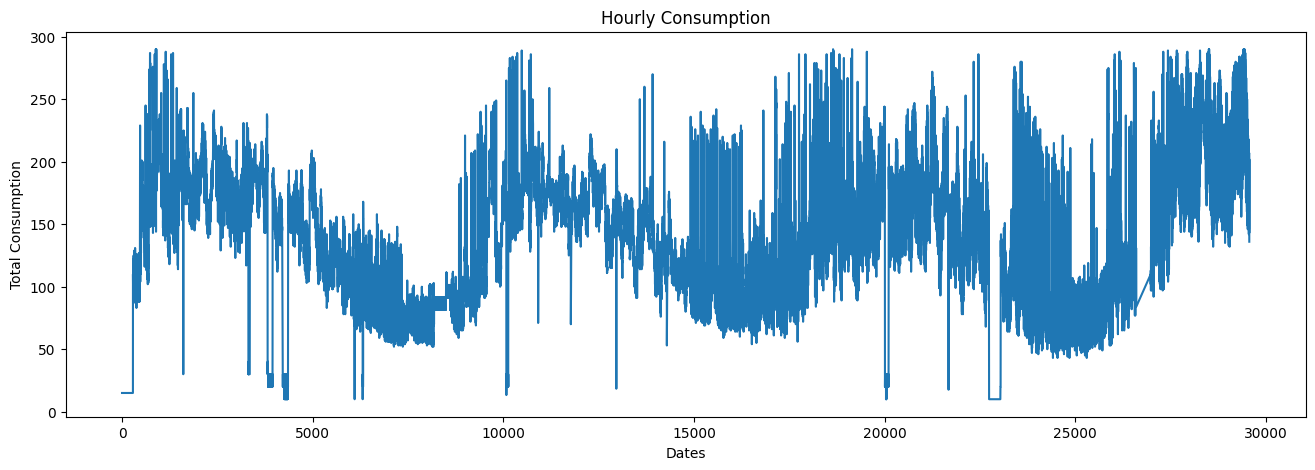

In [17]:
#Basic Data Plot
model_data.index.freq = 'H'
ax = model_data['y'].plot(figsize = (16,5), title = "Hourly Consumption")
ax.set(xlabel='Dates', ylabel='Total Consumption')

In [18]:
from xgboost import XGBRegressor

# Create the model (solo or ensemble)
model = XGBRegressor(
    objective='reg:squarederror',  # Set the appropriate objective based on your task (regression, classification, etc.)
    n_estimators=100,  # Set the number of boosting rounds
    max_depth=3,  # Set the maximum depth of each tree
    learning_rate=0.1  # Set the learning rate
    # Add any other desired hyperparameters
)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
saved_y_test = scaler.inverse_transform(saved_y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

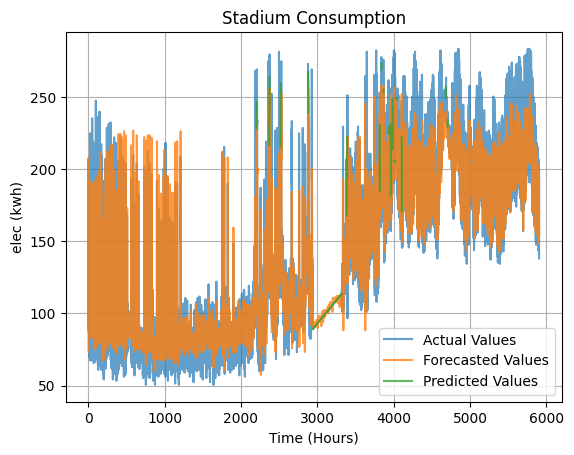

In [19]:
# plot results
fig, ax = plt.subplots()

# Plot the actual values
ax.plot(y_test, label='Actual Values', alpha=0.7)
# ax.plot(np.concatenate([y_train, y_test]), label='Actual Values')

# Plot the predictions
ax.plot(y_pred, label='Forecasted Values', alpha=0.8)
# ax.plot(range(train_len, train_len + len(y_test)), y_pred, label='Predicted Values')

# Plot the replaced missing values
nan_mask = np.isnan(saved_y_test)  # boolean mask of NaN values in saved_y
y_test[~nan_mask] = np.nan

ax.plot(y_test, label='Predicted Values', alpha=0.75)

ax.set_title(f'{bldgname} Consumption')
ax.set_xlabel('Time (Hours)')
ax.set_ylabel(y.split('_')[-2] + ' (' + y.split('_')[-1] + ')')

ax.legend()
plt.grid(True)